In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

# Overview

Students under the F-1 visa usually apply for Optional Practical Training (OPT) to get work authorization from US Citizenship and Immigration Services (USCIS) for internships / jobs. It is also the ultimate test of one's patience. Even after one has braved the inane paperworks and countless trips to advisors / international student offices, one would still have to wait up to 90 days for the authorization approval. **What makes this wait worse is the lack of updates during the wait.** When one applies for OPT (and the application is received by USCIS), one gets a receipt number. Using this receipt number to check one's progress (at [https://egov.uscis.gov/casestatus/mycasestatus.do](https://egov.uscis.gov/casestatus/mycasestatus.do)) is highly unsatisfying. Until the work authorization is approved (or God forbid rejected / put on hold for additional evidence), one is faced with rather useless description that reads something like this:

> 'On February 22, 2016, we received your Form I-765, Application for Employment Authorization , Receipt Number EAC1690120079, and sent you the receipt notice that describes how we will process your case. Please follow the instructions in the notice. If you do not receive your receipt notice by March 23, 2016, please call Customer Service at 1-800-375-5283. If you move, go to www.uscis.gov/addresschange to give us your new mailing address.'

USCIS does a really bad job of keeping one updated on the progress of a case and in general how far along they are going with the entire year's batch of students.

**Fortunately, we can do better.**

# Receipt Numbers

USCIS issues receipt numbers in chronological order. That means if I submitted my application on March 1, 2016 and I got the number YSC1690079958, the next person to submit his application gets the number YSC169007995**9**. The person before me gets the number YSC169007995**7**. Using this fact, I can see how people before and after me are doing. USCIS also states that the cases are processed in a first-come-first-serve order.

- If a huge proportion of people before (and possibly after) me have their OPTs approved, I should have mine processed soon.
- However, if the people who submitted around my date are stil waiting for their approval, I can expect to wait a long time.

However, doing so manually at [https://egov.uscis.gov/casestatus/mycasestatus.do](https://egov.uscis.gov/casestatus/mycasestatus.do) is a slow and tiring process. Instead, I can write a script to "scrape" the website for the 50,000 or so cases before and after my own number.

> Additional note: This year, there are two USCIS centers processing OPT applications -- the Vermont office and the Potomac office. The Potomac office opened later in the cycle (around March) to help with the application volume. [https://www.uscis.gov/news/potomac-service-center-now-processing-certain-form-i-765-cases](https://www.uscis.gov/news/potomac-service-center-now-processing-certain-form-i-765-cases). Applications that are sent to the Vermont office first have the prefix `EAC`. Those may be then routed to the Potomac office. Applications that are sent in late March and later are sent directly to the Potomac office, giving them the prefix `YSC`. This means that when I scrape the pages for data, I have to account for both prefixes.

I planned to scrape receipt numbers `EAC1690120000` to `EAC1690180000` and `YSC1690040000` to `YSC1690080000`. This should give me a good sense of applications submitted in the February to April period.

# Scraping

## IP Blocking

I first wrote a simple `Node.JS` script to do this. I didn't use `python` because `async` in `python` is a pain in the ass.

```js
var cheerio = require('cheerio');
var request = require('request');
var async = require('async');
var fs = require('fs');
var stringify = require('csv-stringify');

var URL = 'https://egov.uscis.gov/casestatus/mycasestatus.do?appReceiptNum=RECEIPT_NUM';
var PREFIX = 'EAC';
var START_NUMBER = 1690120000;
var END_NUMBER = 1690180000;

var receiptNumbers = [];
for (var i = START_NUMBER; i < END_NUMBER; i++) {
  receiptNumbers.push(PREFIX + i);
}
fs.writeFileSync('raw_data.csv', 'receipt,title,text\n');

function retrieveReceiptNumber(receiptNumber, callback) {
  request({
      url: URL.replace('RECEIPT_NUM', receiptNumber),
      rejectUnauthorized: false
    },
    function (err, resp, body) {
      if (err) {
        console.error(err);
      }
      var $ = cheerio.load(body);
      var title = $('.appointment-sec').find('.text-center').find('h1').text();
      var description = $('.appointment-sec').find('.text-center').find('p').text();

      var violation = $('label[for=accessviolation]').text();

      if (title.length == 0) {
        if (violation.length > 0) {
          console.log('access violation');
        }
        callback();
      } else {
        var row = [
          [receiptNumber, title, description]
        ];

        stringify(row, function (err, output) {
          if (err) {
            console.error(err);
          }
          fs.appendFile('raw_data.csv', output, function (err) {
            if (err) {
              console.error(err);
            }
            console.log(receiptNumber + ' written');
            callback();
          });
        });
      }
    });
}

async.eachLimit(receiptNumbers, 100, retrieveReceiptNumber, function (err) {
  if (err) {
    console.error(err);
  }
  console.log('DONE');
});
```

## Scrapoxy

USCIS (unsurprisingly) blocked my IP after around 2,000 queries. So I needed a way to get around the IP blocking. Fortunately, an easy solution was available: [http://scrapoxy.io/](http://scrapoxy.io/). Scrapoxy manages a pool of EC2 / DigitalOcean instances for you (afte some setting up) and provides a single local port for you as a proxy. This allows you to route your requests through the multiple cloud instances. This lowers the likelihood of a single IP getting blocked. (Even if one gets blocked, you can simply kill the instance and restart it. I didn't have to do this, sine none of the cloud instances got blocked). After setting up Scrapoxy and running the proxy at `http://localhost:8888`, I can pass this easily to the `request` module in my script:

```js
var cheerio = require('cheerio');
var request = require('request');
var async = require('async');
var fs = require('fs');
var stringify = require('csv-stringify');

var URL = 'https://egov.uscis.gov/casestatus/mycasestatus.do?appReceiptNum=RECEIPT_NUM';
var PREFIX = 'EAC';
var START_NUMBER = 1690149000;
var END_NUMBER = 1690180000;

var receiptNumbers = [];
for (var i = START_NUMBER; i < END_NUMBER; i++) {
  receiptNumbers.push(PREFIX + i);
}
fs.writeFileSync('raw_data.csv', 'receipt,title,text\n');

function retrieveReceiptNumber(receiptNumber, callback) {
  request({
      url: URL.replace('RECEIPT_NUM', receiptNumber),
      rejectUnauthorized: false,
      proxy: 'http://localhost:8888',
      tunnel: false // remember to set tunnel to false
    },
    function (err, resp, body) {
      if (err) {
        console.error(err);
      }
      var $ = cheerio.load(body);
      var title = $('.appointment-sec').find('.text-center').find('h1').text();
      var description = $('.appointment-sec').find('.text-center').find('p').text();

      var violation = $('label[for=accessviolation]').text();

      if (title.length == 0) {
        if (violation.length > 0) {
          console.log('access violation');
        }
        callback();
      } else {
        var row = [
          [receiptNumber, title, description]
        ];

        stringify(row, function (err, output) {
          if (err) {
            console.error(err);
          }
          fs.appendFile('raw_data.csv', output, function (err) {
            if (err) {
              console.error(err);
            }
            console.log(receiptNumber + ' written');
            callback();
          });
        });
      }
    });
}

async.eachLimit(receiptNumbers, 100, retrieveReceiptNumber, function (err) {
  if (err) {
    console.error(err);
  }
  console.log('DONE');
});
```

The changes are in the options object passed to `request`:

```js
{
  url: URL.replace('RECEIPT_NUM', receiptNumber),
  rejectUnauthorized: false,
  proxy: 'http://localhost:8888',
  tunnel: false // remember to set tunnel to false
}
```

This allows me to scrape the receipt numbers very quickly within the hour. (see the `eachLimit` for `async`? I'm making 100 requests at any time through the proxy). I collected the scraped results into `raw_data_eac.csv` and `raw_data_ysc.csv` for the two prefixes.

Now let's analyze them.

In [2]:
import csv
import pandas

# Parsing Data

Earlier, I only scraped the raw data from the pages. Hence, I only have the `receipt` (receipt number), `title` (the short line of text displayed at the top of each case status) and `text` (the full text of the case status). This is hardly useful. Here's what the raw data looks like:

In [3]:
data_eac = pandas.read_csv('raw_data_eac.csv')
data_ysc = pandas.read_csv('raw_data_ysc.csv')
data = data_eac.append(data_ysc)

In [4]:
data

,receipt,title,text
0,EAC1690120011,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."
1,EAC1690120006,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."
2,EAC1690120001,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."
3,EAC1690120003,Case Was Transferred And A New Office Has Juri...,"On March 11, 2016, we transferred your Form I-..."
4,EAC1690120002,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."
5,EAC1690120009,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."
6,EAC1690120012,Card Was Delivered To Me By The Post Office,"On May 13, 2016, the Post Office delivered you..."
7,EAC1690120010,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."
8,EAC1690120000,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."
9,EAC1690120004,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7..."


I can use this information to create a `status` for each receipt number. I'm using a lot of simplifying assupmtions here and disregarding a lot of corner cases (USCIS sometimes requests additional evidence, does weird thing with cases etc.) In fact, let's take a look at the vaious case `title`s:

In [5]:
data.groupby('title').count()['receipt']

title
Amended Notice Was Mailed                                                             8
Appeal Was Dismissed                                                                  9
Card Is Being Returned to USCIS by Post Office                                       10
Card Returned Undeliverable                                                           4
Card Was Delivered To Me By The Post Office                                       11434
Card Was Determined As Undeliverable By The Post Office                              26
Card Was Mailed To Me                                                              2045
Card Was Picked Up By The United States Postal Service                              162
Card Was Received By USCIS Along With My Letter                                       4
Card Was Returned And USCIS Is Holding It For One Year                               20
Card Was Returned To USCIS By Post Office                                             7
Case Is Pending at a Local

I ignore most of the corner cases and only look at a few larger categories:

- If the word `I-765` appears in the `text` of a case (since we are only looking at OPT cases), and `Case Was Received` is in the `title`, then the case is still processing. This happens when USCIS receives the case. Most people enduring the long 60 to 90 day wait will see this.
- If the word `I-765` appears in the `text` of a case, and `Case Was Transferred` is in the `title`, then the case was probably submitted to the Vermont office first then routed to the Potomac office. This is still `processing` as well.
- If the word `I-765` appears in the `text` of a case, and `Case Was Rejected`, well sucks for you. The case is rejected.
- If the word `I-765` appears in the `text` of a case and `Case Was Approved`, congratulations! Your case is approved.
- Even better, if a card is made and being delieverd, you'd have the `Card Was Delivered To Me By The Post Office` in the `title` of the case.
- Finally, if your card is being made and still not delivered, you'd have the title `New Card Is Being Produced`

I make a silly function for this and iterate over each row of the dataframe.

In [6]:
def gen_status(row):
    if 'I-765' in row['text'] and 'Case Was Received' in row['title']:
        return 'processing'
    if 'I-765' in row['text'] and 'Case Was Transferred' in row['title']:
        return 'processing'
    if 'I-765' in row['text'] and 'Case Was Rejected' in row['title']:
        return 'rejected'
    if 'I-765' in row['text'] and 'Case Was Approved' in row['title']:
        return 'approved'
    if row['title'] == 'Card Was Delivered To Me By The Post Office':
        return 'approved'
    if row['title'] == 'New Card Is Being Produced':
        return 'approved'
    return ''

data_24['status'] = data_24.apply(gen_status, axis=1)
data_26['status'] = data_26.apply(gen_status, axis=1)

Now here's a slightly harder part. Only in the `Case Was Received` cases do we have a **submission date** for the OPT application. For the others (approved or rejected) the case status `text` only contains the date that the case was approved (which I am really not interested in for now). I want to know when those cases are **submitted**. Fortunately, I can again exploit the fact that the numbers are in increasing order. When the date of a case cannot be determined, I simply look backwards (to earlier receipt numbers) to the last known date of a still processing case. This gives me a good approximation of the submission dates of approved / rejected cases.

In [7]:
import re
import numpy
pattern = re.compile('On ([A-z]+ [0-9]+, [0-9]+),')

last_date = None
def extract_date(row):
    if row['status'] == 'processing':
        m = pattern.search(row['text'])
        global last_date
        last_date = numpy.datetime64(pandas.Timestamp(m.group(1)))
        return last_date
    return last_date

data['date'] = data.apply(extract_date, axis=1)

Our processed data looks like this:

In [8]:
data

,receipt,title,text,status,date
0,EAC1690120011,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09
1,EAC1690120006,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09
2,EAC1690120001,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09
3,EAC1690120003,Case Was Transferred And A New Office Has Juri...,"On March 11, 2016, we transferred your Form I-...",processing,2016-03-11
4,EAC1690120002,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09
5,EAC1690120009,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09
6,EAC1690120012,Card Was Delivered To Me By The Post Office,"On May 13, 2016, the Post Office delivered you...",approved,2016-03-09
7,EAC1690120010,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09
8,EAC1690120000,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09
9,EAC1690120004,Case Was Transferred And A New Office Has Juri...,"On March 9, 2016, we transferred your Form I-7...",processing,2016-03-09


# Results

Now I can look at the results. First, I group the data by the `date` column. Cases (rows) with the same date will be grouped together. Then, for each date, I count the number of `processing`, `approved`, and `rejected` cases.

In [9]:
result = pandas.DataFrame(data[data['status'] == 'processing'].groupby('date')['receipt'].count())
result['approved'] = data[data['status'] == 'approved'].groupby('date')['receipt'].count()
result['rejected'] = data[data['status'] == 'rejected'].groupby('date')['receipt'].count()
result.columns = ['Processing', 'Approved', 'Rejected']

And I make a silly plot.

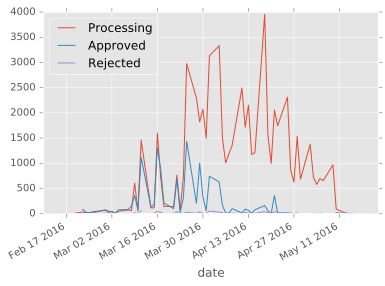

In [10]:
result.plot()

Here's how to interpret this data. I can see that most of the cases submitted in February and early March are already processed. The ones submitted in later March are around 50% processed. The ones submitted in late March (like mine) are beginning to get approved.

For each date, I can see the number of cases approved, rejected, processing etc.

In [11]:
result.loc['2016-03-30']

Processing    2069.0
Approved       328.0
Rejected         5.0
Name: 2016-03-30 00:00:00, dtype: float64

I can make this more readable by dividing the number of approved cases by the total number of processing, approved, and rejected cases.

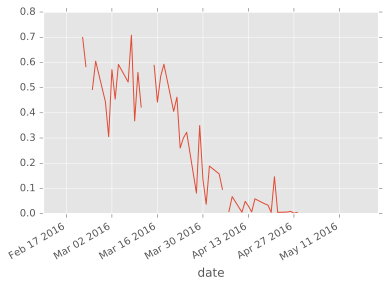

In [12]:
result['Total'] = result['Processing'] + result['Approved'] + result['Rejected']
result['Approved Proportion'] = result['Approved'] / result['Total']
result['Approved Proportion'].plot()

I really don't understand why USCIS would not release this data (since it will help calm the nerves of so many international students). I do hope that this will help calm your nerves though as it did calm mine.